# Test User Afib Detection

I found a volunteer to donate their fitbit heart rate data and a log of their atrial fibulation (afib) episodes, this notebook will endeavor to build a detector that can automatically recognize afib episodes.

In [1]:
import pandas as pd
import json

import psycopg2
conn = psycopg2.connect(host='ec2-107-20-166-28.compute-1.amazonaws.com',
                        user='rbhciitblovwew',
                        database='db274el0c49tdu')

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(rc={"figure.figsize": (16, 9)})
sns.set(style="whitegrid")

from sklearn.cluster import MeanShift, KMeans
import numpy as np

In [3]:
query = """
SELECT *
FROM activity_journal_minutes
WHERE user_id = 2
AND heart_dttm BETWEEN '2016-08-07' AND '2016-12-27'
"""
comb_journals = pd.read_sql(query, conn, parse_dates=['step_dttm', 'heart_dttm', 'journal_date'])
comb_journals.head()

,user_id,steps,bpm,journal_date,step_dttm,heart_dttm
0,2,0,58,2016-08-07,2016-08-07 00:00:00,2016-08-07 00:00:00
1,2,0,58,2016-08-07,2016-08-07 00:01:00,2016-08-07 00:01:00
2,2,0,58,2016-08-07,2016-08-07 00:02:00,2016-08-07 00:02:00
3,2,0,58,2016-08-07,2016-08-07 00:03:00,2016-08-07 00:03:00
4,2,0,58,2016-08-07,2016-08-07 00:04:00,2016-08-07 00:04:00


In [4]:
# NOTE: These dates/times are in PST
episode_log = [
    ['2016-08-08 02:00:00', '2016-08-08 05:07:00'],
    ['2016-09-02 21:15:00', '2016-09-03 02:15:00'],
    ['2016-10-20 16:30:00', '2016-10-20 18:30:00'],
    ['2016-11-07 16:30:00', '2016-11-07 19:00:00'],
    ['2016-12-14 15:15:00', '2016-12-14 17:45:00'],
    ['2016-12-24 03:20:00', '2016-12-24 06:00:00'],
    ['2016-12-26 08:00:00', '2016-12-26 09:45:00']
]

In [ ]:
# according to the fitbit API, these values should already be in the user's timezone (Pacific in this case)
pd.to_datetime(episode_log[0][0]).tz_localize('US/Pacific')

In [5]:
# Label each record as in afib or not
comb_journals['afib'] = False

for log in episode_log:
    episode_start = pd.to_datetime(log[0])#.tz_localize('US/Pacific').tz_convert(None)
    episode_end = pd.to_datetime(log[1])  #.tz_localize('US/Pacific').tz_convert(None)
    comb_journals['afib'][ (comb_journals['heart_dttm'] >= episode_start) &
                   (comb_journals['heart_dttm'] <  episode_end)
                 ] = True

    
comb_journals[comb_journals['afib'] == True].count()

/home/brycemcd/anaconda2/envs/typical_stack/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


user_id         1151
steps           1151
bpm             1151
journal_date    1151
step_dttm       1151
heart_dttm      1151
afib            1151
dtype: int64

In [ ]:
sns.stripplot(data=comb_journals, y='bpm', x='afib', jitter=True)
plt.show()

In [ ]:
comb_journals[ comb_journals['bpm'] > 150 ]

Heart rate alone does not seem to separate the data very well. For graphical purposes, I'll look at the relationship of steps and heart rate.

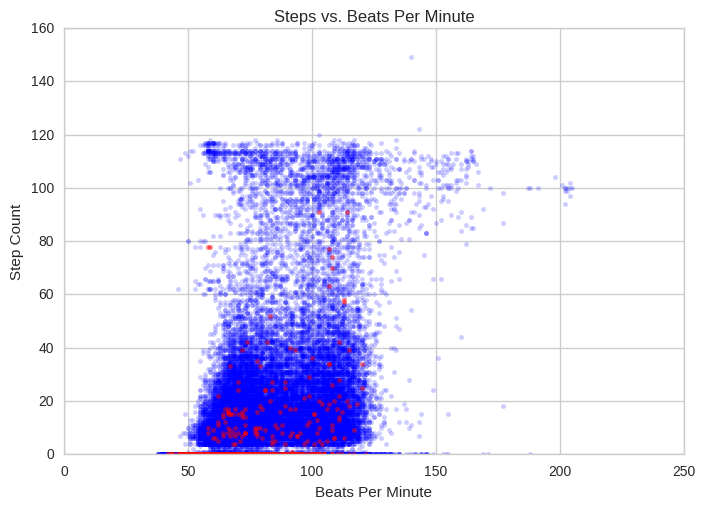

In [19]:
normal = comb_journals[ comb_journals['afib'] == False ]
afib = comb_journals[ comb_journals['afib'] == True ]

plt.plot(normal['bpm'], normal['steps'], 'b.', alpha=0.2)
plt.plot(afib['bpm'], afib['steps'], 'r.', alpha=0.5)

plt.title("Steps vs. Beats Per Minute")
plt.ylabel("Step Count")
plt.xlabel("Beats Per Minute")
plt.show()

In [11]:
comb_journals[['steps', 'bpm']].corr()

,steps,bpm
steps,1.000000,0.455076
bpm,0.455076,1.000000


In [ ]:
comb_journals['hr_to_step_ratio'] = comb_journals['bpm'] / (comb_journals['steps'] + 1) # +1 avoid div by zero errors
comb_journals.head()

In [ ]:
sns.stripplot(data=comb_journals, y='hr_to_step_ratio', x='afib', jitter=True, alpha=0.2)
plt.show()

TODO: There's not much separation in the data and given that some of the labeled afib events show bpm < 60, I think there is a problem matching the event log to the event in the fitbit dataset.

+ Look at API docs to see if step AND bpm data coming from fitbit are both reported in UTC

> Fitbit does not support time zones for data. Users can specify a time zone in their settings, but this offset is only used to determine the start of their 24-hour period. As such, there is no way to request a specific time zone, because all data is aligned with the user's specified UTC offset.

> All date and time related fields in the API requests and responses are rendered in the local time of the resource owner's timezone (either authorized user or the owner of the resource requested).

+ Make sure event log and fitbit data is paired in the same timezone
+ Get feedback from user about what's happening when bpm is > 130 && an event is not reported

In [ ]:
comb_journals['heart_time'] = comb_journals['heart_dttm'].dt.time

In [ ]:
event_day = comb_journals[ comb_journals['journal_date'] == '2016-12-24']
plt.plot(event_day['heart_dttm'], event_day['bpm'], 'm.', alpha=0.5)
plt.plot(event_day['heart_dttm'], event_day['steps'], 'g.', alpha=0.5)
plt.axvspan('2016-12-24 03:20:00', '2016-12-24 06:00:00', color='red', alpha=0.5)
plt.show()

In [ ]:
event_day = comb_journals[ comb_journals['journal_date'] == '2016-12-24']
plt.plot(event_day['heart_dttm'], event_day['hr_to_step_ratio'], 'm.', alpha=0.5)
plt.axvspan('2016-12-24 03:20:00', '2016-12-24 06:00:00', color='red', alpha=0.5)
plt.show()

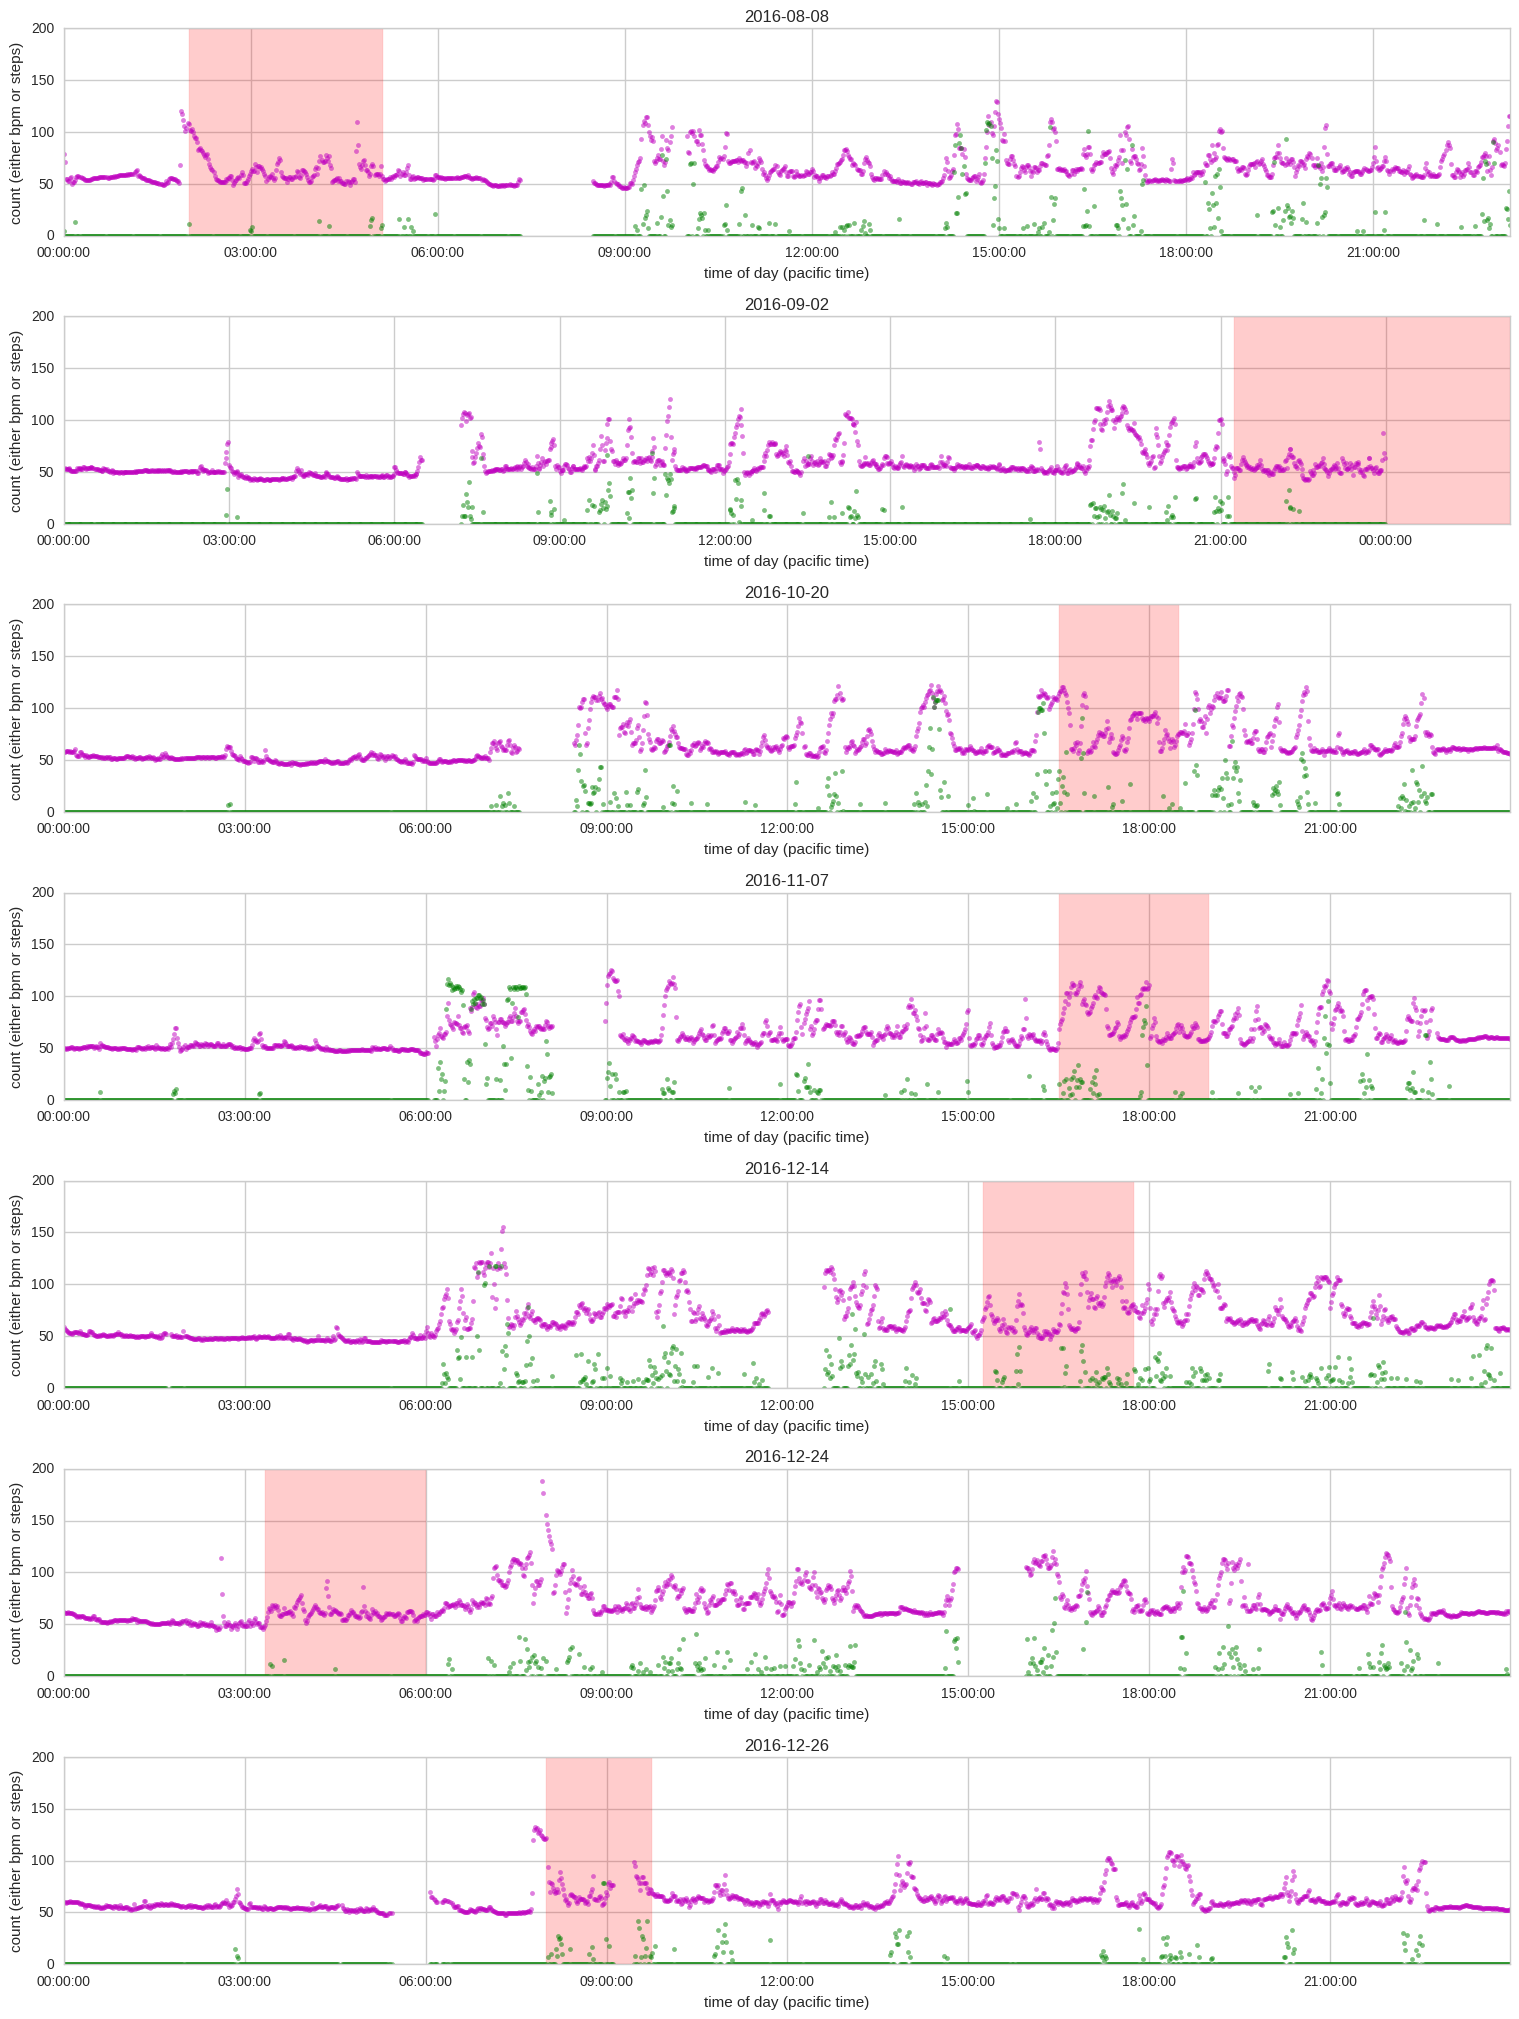

In [20]:
# try plotting the above for each event

# set up subplots
i = 0
total_subplots = len(episode_log)
f, axarr = plt.subplots(total_subplots, sharey=True, figsize=(15, 20))

for event in episode_log:
    event_d = comb_journals[ comb_journals['journal_date'] == pd.to_datetime(event[0]).date()]
    axarr[i].plot(event_d['heart_dttm'], event_d['bpm'], 'm.', alpha=0.5)
    axarr[i].plot(event_d['heart_dttm'], event_d['steps'], 'g.', alpha=0.5)
    axarr[i].axvspan(event[0], event[1], color='red', alpha=0.2)
    
    axarr[i].set_title(pd.to_datetime(event[0]).date())
    axarr[i].set_ylabel('count (either bpm or steps)')
    axarr[i].set_xlabel('time of day (pacific time)')
    i = i + 1
    
    
plt.tight_layout(pad=0.0, h_pad=1.0)
plt.show()

There is a lot of overlap in the raw data irrespective of an afib event. I'm going to attempt to smooth out some of the events and use different measures to see if more obvious patterns emerge